<a href="https://colab.research.google.com/github/basilsaju383/ML_project1/blob/main/anomaly_detection_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# Load data from Excel
data = pd.read_excel('/content/sample_data/mc4 GSM 3 month.xlsx')

In [ ]:
data.columns

Index(['Day', 'Date', 'Time', 'Device Name', 'Location', 'GPS Location',
       'Aggregation', 'RSRP', 'RSRQ', 'RSSI', 'SNR'],
      dtype='object')

In [ ]:
df = data['RSSI']
df = df.dropna()
df

1918     -61.000000
1925     -62.000000
1941     -63.000000
1956     -66.000000
1971     -62.000000
            ...    
132303   -63.000000
132318   -65.000000
132333   -63.000000
132349   -66.000000
132660   -64.349377
Name: RSSI, Length: 4655, dtype: float64

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
X_train = X_train.values.reshape((-1, 1))
X_test = X_test.values.reshape((-1, 1))


In [ ]:

model = keras.Sequential([
    layers.BatchNormalization(input_shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

In [ ]:

model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
EPOCHS = 500
history = model.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    batch_size=64,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    verbose=1,
)

Epoch 1/500
58/59 [============================>.] - ETA: 0s - loss: 63.4769 - mae: 63.4769
Epoch 1: val_loss improved from inf to 62.46822, saving model to best_model.h5
59/59 [==============================] - 2s 14ms/step - loss: 63.4734 - mae: 63.4734 - val_loss: 62.4682 - val_mae: 62.4682
Epoch 2/500
13/59 [=====>........................] - ETA: 0s - loss: 62.0876 - mae: 62.0876

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/59 [==========================>...] - ETA: 0s - loss: 60.7233 - mae: 60.7233
Epoch 2: val_loss improved from 62.46822 to 58.75595, saving model to best_model.h5
59/59 [==============================] - 1s 11ms/step - loss: 60.5924 - mae: 60.5924 - val_loss: 58.7559 - val_mae: 58.7559
Epoch 3/500
54/59 [==========================>...] - ETA: 0s - loss: 53.6903 - mae: 53.6903
Epoch 3: val_loss improved from 58.75595 to 47.56165, saving model to best_model.h5
59/59 [==============================] - 1s 10ms/step - loss: 53.1954 - mae: 53.1954 - val_loss: 47.5617 - val_mae: 47.5617
Epoch 4/500
59/59 [==============================] - ETA: 0s - loss: 31.5063 - mae: 31.5063
Epoch 4: val_loss improved from 47.56165 to 31.62151, saving model to best_model.h5
59/59 [==============================] - 1s 10ms/step - loss: 31.5063 - mae: 31.5063 - val_loss: 31.6215 - val_mae: 31.6215
Epoch 5/500
58/59 [============================>.] - ETA: 0s - loss: 4.6192 - mae: 4.6192
Epoch 5: val_loss impr

In [ ]:
reconstructions = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

30/30 [==============================] - 0s 2ms/step


In [ ]:
threshold = np.mean(mse) + 4 * np.std(mse)

In [ ]:
anomalies = np.where(mse > threshold)[0]
print("Anomalies:", anomalies)

Anomalies: [319]


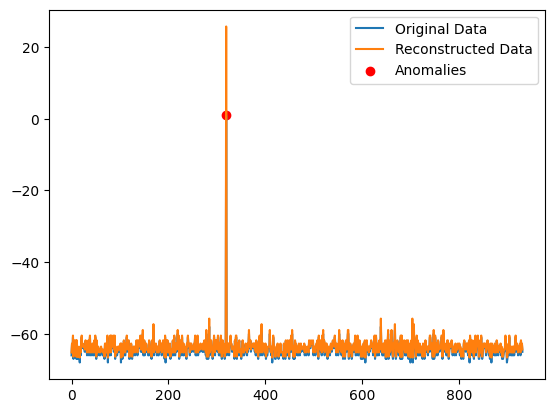

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_test, label='Original Data')
plt.plot(reconstructions, label='Reconstructed Data')
plt.scatter(anomalies, X_test[anomalies], color='red', marker='o', label='Anomalies')
plt.legend()
plt.show()

In [ ]:
precision = len(anomalies) / (len(anomalies) + len(np.where(mse <= threshold)[0]))
true_positives = len(np.intersect1d(anomalies, np.where(mse > threshold)[0]))
false_negatives = len(anomalies) - true_positives
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.0010741138560687433
Recall: 1.0
F1-score: 0.002145922746781116


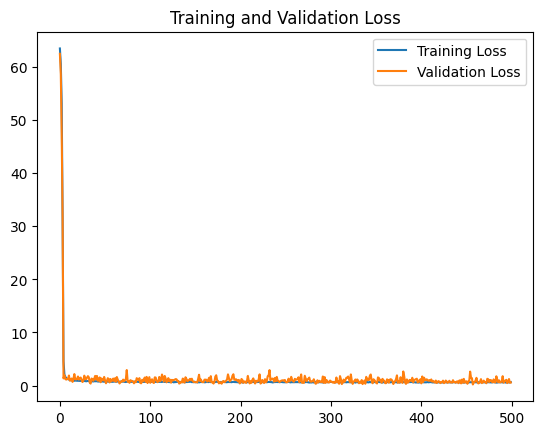

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
best_model = keras.models.load_model('best_model.h5')

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, X_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

30/30 [==============================] - 0s 4ms/step - loss: 0.2099 - mae: 0.2099
Test Loss: 0.2099020630121231, Test Accuracy: 0.2099020630121231
